In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner

matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/cosmo/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,5).reshape(-1, 1)
ninit = 4
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

f_mean = 0.33
f_std = 0.2
f = lambda x: -0.5*(x-f_mean)**2 / f_std**2  

train_y = f(train_x)
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=1)
start = time.time()
mu, var = gp.posterior(test_x,single=True)

print(f"predicting took {time.time() - start:.4f}s\n")

Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1370.32it/s, 3 steps of size 4.65e-01. acc. prob=0.89]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     34.84     87.41      6.78      0.12     90.37    329.04      1.00
        kernel_length[0]      0.41      0.16      0.41      0.18      0.72    334.89      1.00
            kernel_tausq      3.40      9.27      0.81      0.01      7.95    250.43      1.00
              kernel_var     13.00      9.19     10.46      1.02     25.24    347.86      1.00

Number of divergences: 1

MCMC elapsed time: 1.90s
predicting took 0.1828s



[Text(0.5, 0, 'lengthscale'), Text(0, 0.5, 'outputscale')]

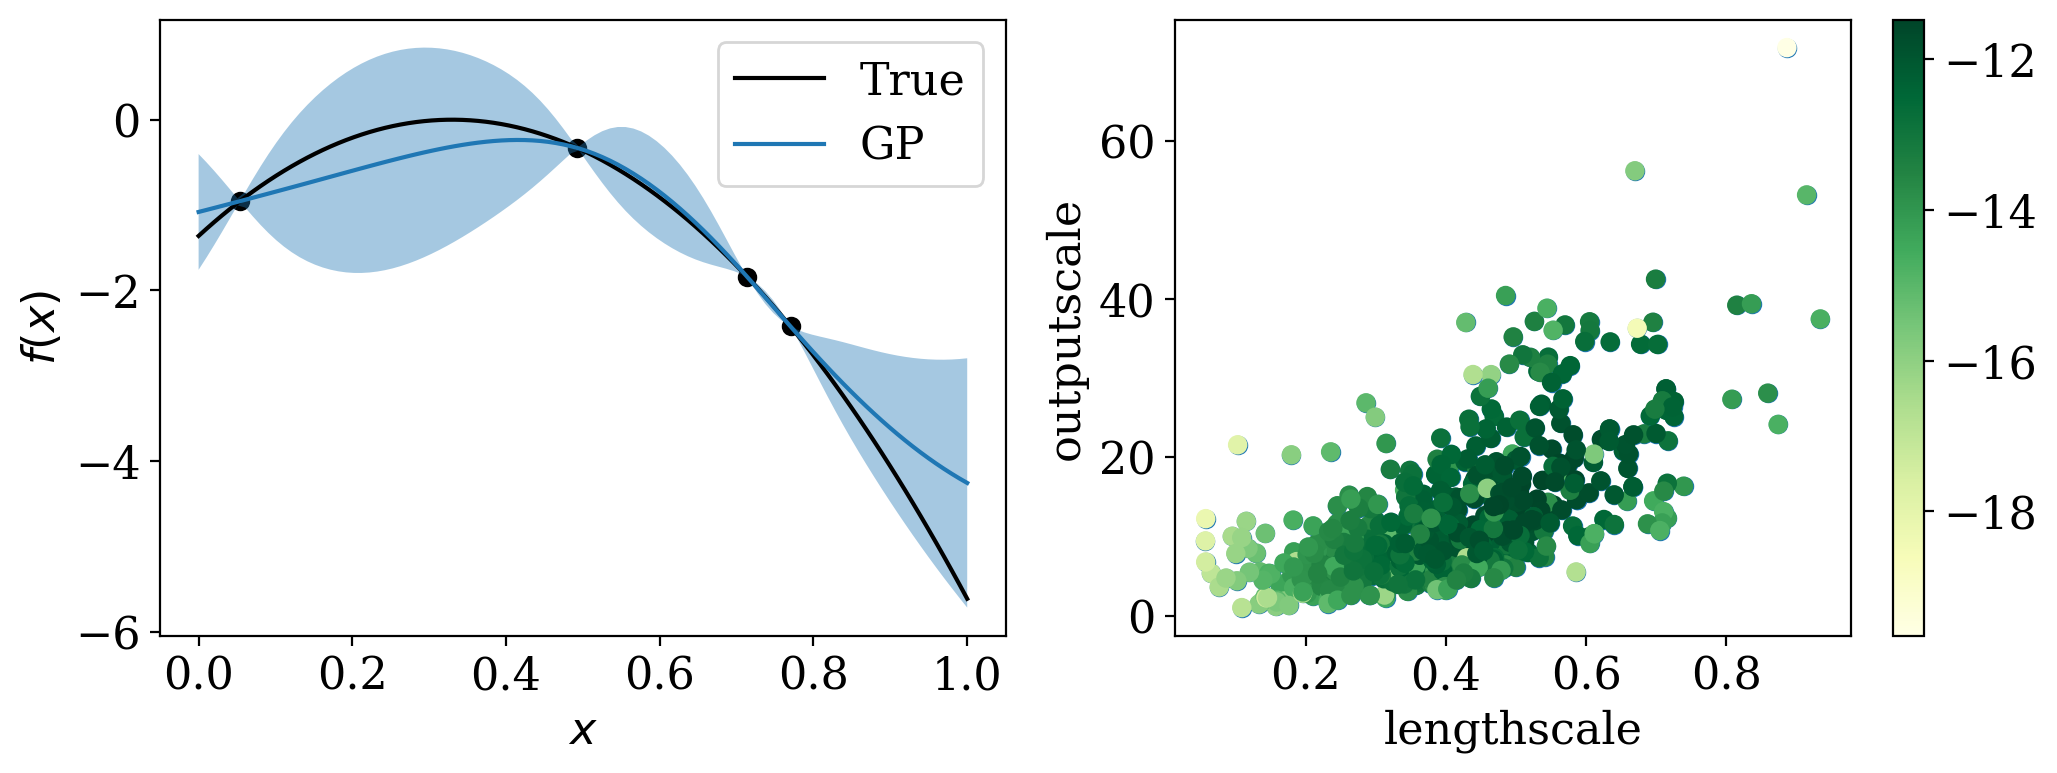

In [3]:
std = jnp.sqrt(var)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(test_x,test_y,label='True',color='k')
ax1.scatter(train_x,train_y,color='k')
ax1.plot(test_x,mu,label='GP')
ax1.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
ax1.set(xlabel=r'$x$',ylabel=r'$f(x)$')
ax1.legend()



colors = matplotlib.colormaps['YlGn']

l = np.array(gp.samples["kernel_length"].squeeze(-1))
o = np.array(gp.samples["kernel_var"])
lp = -np.array(gp.samples["minus_log_prob"])
lp_min, lp_max = np.min(lp), np.max(lp)
cols = np.linspace(lp_min,lp_max,len(lp))
cols = (cols - lp_min)/(lp_max - lp_min)


ax2.scatter(l,o)

sc = ax2.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
fig.colorbar(sc,ax=ax2)

ax2.set(xlabel=r'lengthscale',ylabel=r'outputscale')

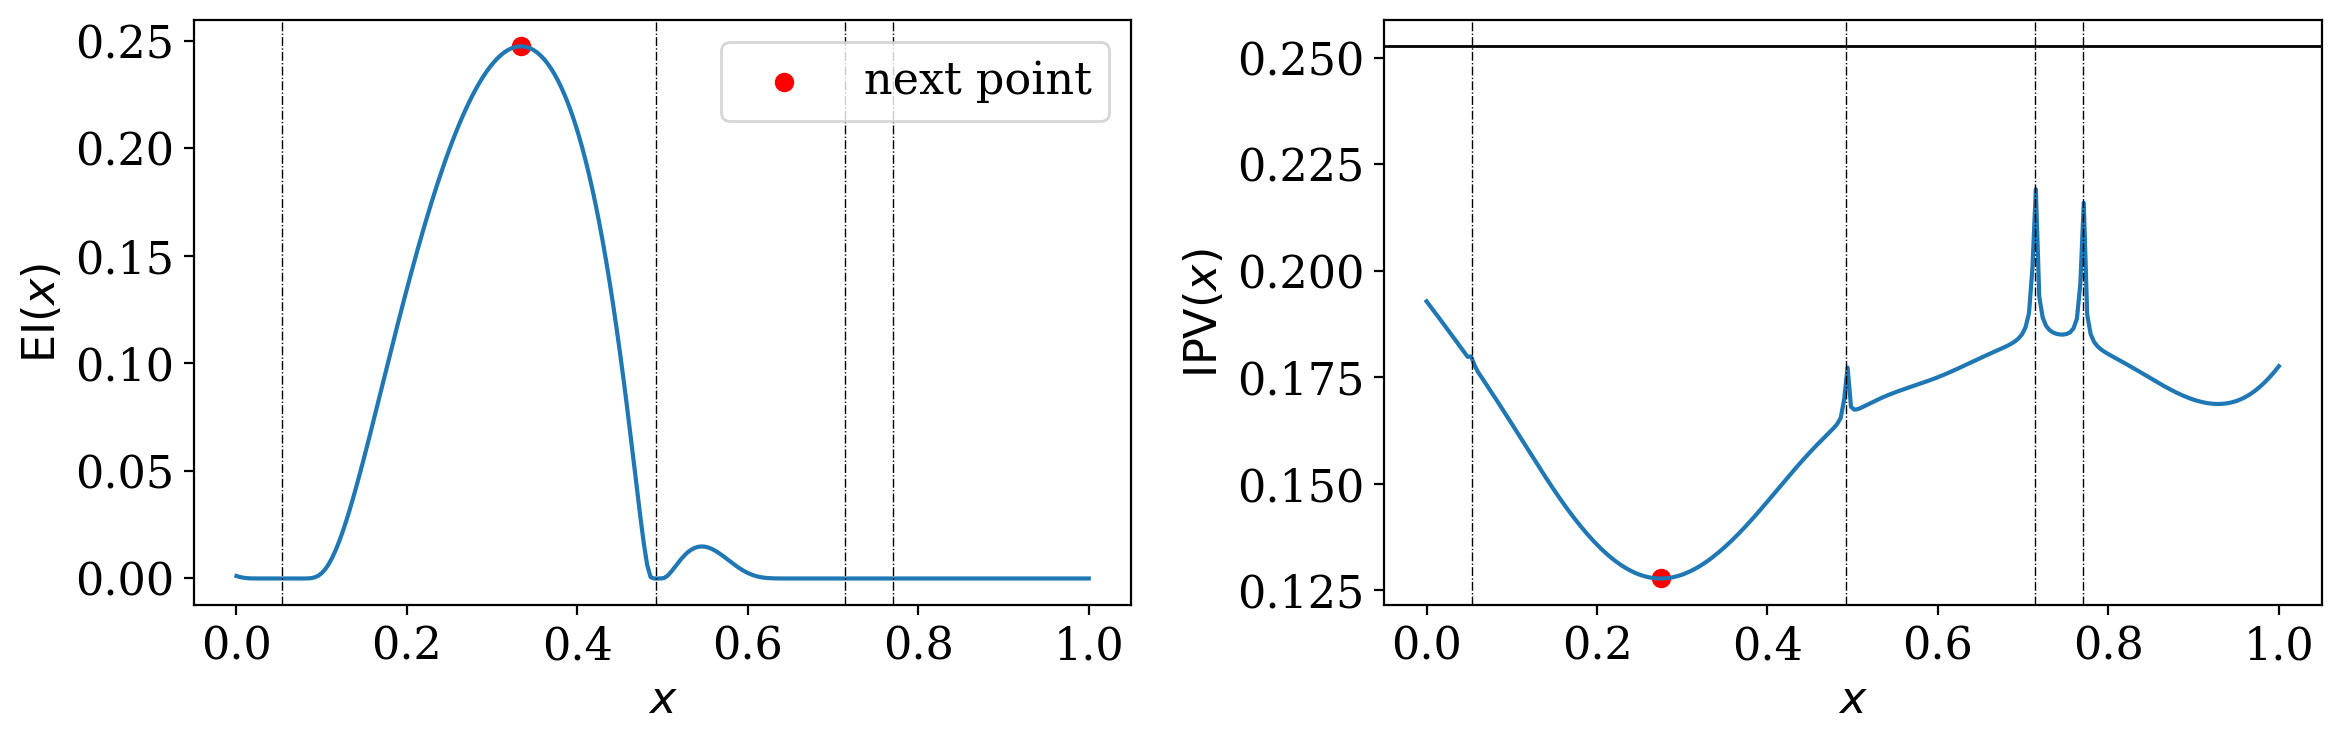

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
acq_func = EI(gp,best_f=gp.train_y.max(),zeta=0.1)
acq_x =  np.linspace(0,1,250).reshape(-1, 1)
acq_vals = -vmap(acq_func)(acq_x)

grad_fn = grad(acq_func)

results = optim_scipy_bh(acq_func,x0=np.random.uniform(),stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': [(0,1)] })
next_x = results.x
next_val = -results.fun

ax1.plot(acq_x,acq_vals)
ax1.scatter(next_x,next_val,color='r',label=r'next point')
ax1.set(xlabel=r'$x$',ylabel=r'$\mathrm{EI}(x)$')
ax1.legend()

mc_points = jnp.linspace(0,1,32).reshape(-1,1)
_, pre_var = gp.posterior(mc_points,unstandardize=False)
pre_var = pre_var.mean()
acq_func = IPV(gp,mc_points)

acq_vals = vmap(acq_func)(acq_x)

grad_fn = grad(acq_func)

results = optim_scipy_bh(acq_func,x0=np.random.uniform(),stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': [(0,1)] })
next_x = results.x
next_val = results.fun

ax2.plot(acq_x,acq_vals)
ax2.scatter(next_x,next_val,color='r',label=r'next point')

ax2.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')

for axes in [ax1,ax2]:
    for pt in train_x:
        axes.axvline(pt,color='k',ls='-.',lw=0.5)
ax2.axhline(pre_var,color='k',lw=1)

fig.tight_layout()

In [5]:
from nested_sampler import nested_sampling_jaxns

samples, logz_dict = nested_sampling_jaxns(gp,ndim=1,dlogz=0.01)

Nested Sampling took 2.6113s
jaxns made 4626 likelihood evaluations
(195, 1)


(1000, 1)
LogZ logz_mean: -1.0290, dlogz: 0.1395, 


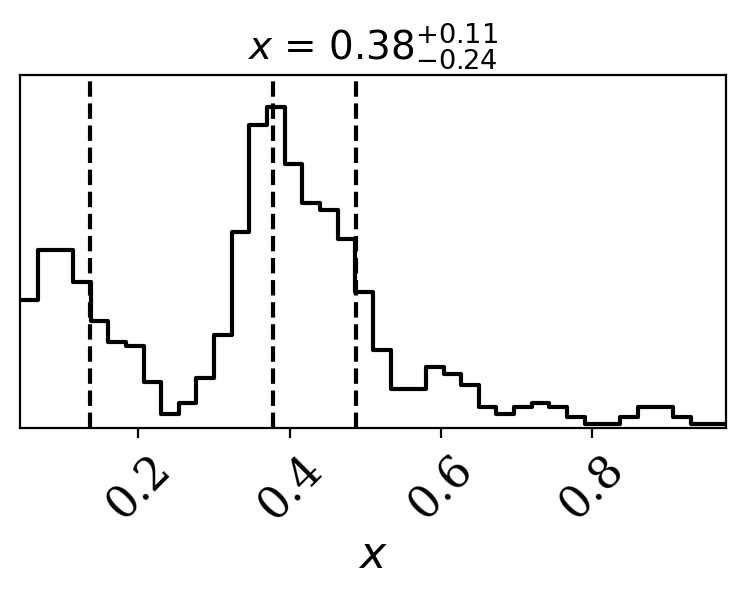

In [6]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

fig = plt.figure(figsize=(6,3))

fig = corner.corner(samples,labels=[
        r"$x$",],
    quantiles=[0.16, 0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=1.,truth=(0.5,),truth_color='red'
)


In [7]:
from nested_sampler import nested_sampling_Dy

samples, logz_dict = nested_sampling_Dy(gp,maxcall=8000,dlogz=0.1,ndim=1)

Nested Sampling took 8.5537s
Log Z evaluated using (1935,) points
Dynesty made 8507 function calls


LogZ mean: -0.9173, upper: -0.5333, lower: -1.2578, dlogz sampler: 0.0368, 
LogZ True = -0.7417


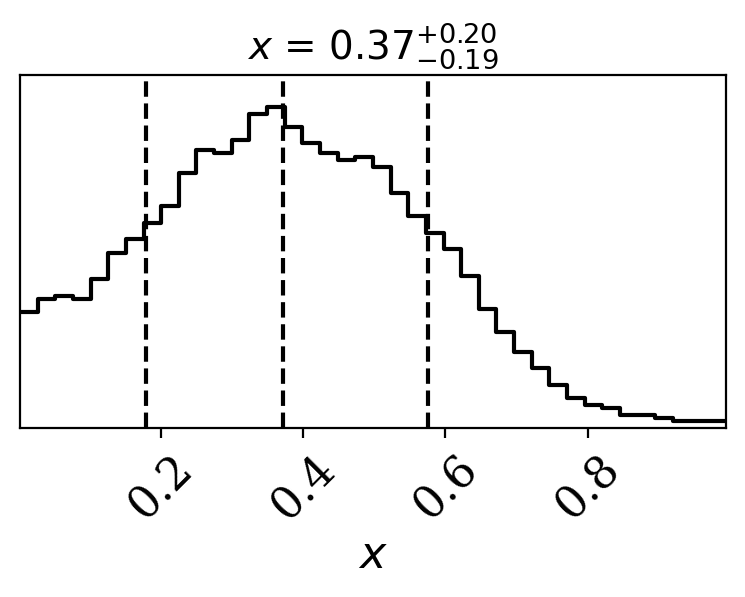

In [8]:
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

x_grid = np.linspace(0,1,500)
logz_true = np.log(np.trapz(np.exp(f(x_grid)),x_grid))
print(f"LogZ True = {logz_true:.4f}")


fig = plt.figure(figsize=(6,3))

fig = corner.corner(samples,labels=[
        r"$x$",],
    quantiles=[0.16, 0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=1.,truth=(0.5,),truth_color='red'
)


### 2D Example

(15, 2) (15, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1499.73it/s, 7 steps of size 6.93e-01. acc. prob=0.91]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      2.81      2.62      2.10      0.39      5.97     47.75      0.98
_kernel_inv_length_sq[1]      4.79      5.37      3.04      0.55      8.86     43.36      1.00
        kernel_length[0]      0.97      0.18      0.94      0.70      1.20     46.50      0.97
        kernel_length[1]      0.77      0.13      0.76      0.57      0.99     50.87      1.00
            kernel_tausq      0.92      0.93      0.46      0.11      2.27    106.97      0.97
              kernel_var     30.94     15.17     28.15     10.94     53.79     54.36      0.97

Number of divergences: 0

MCMC elapsed time: 1.37s


Text(0, 0.5, '$x_2$')

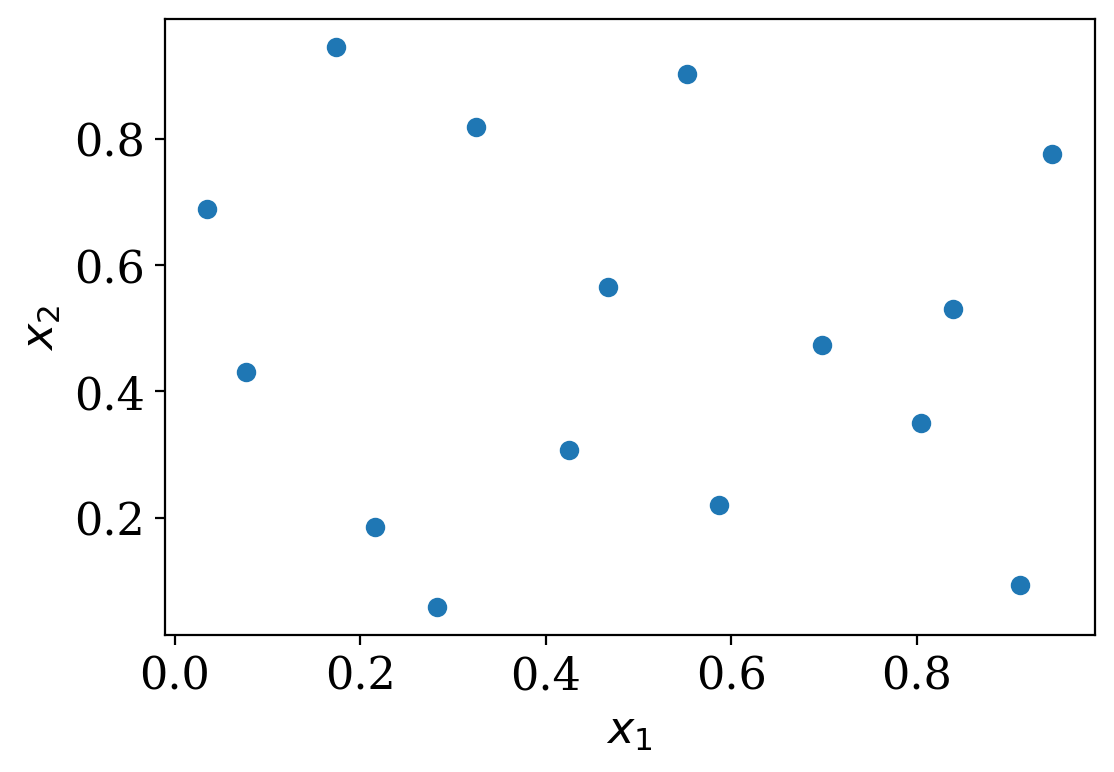

In [9]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 15
ndim = 2
train_x = qmc.Sobol(ndim, scramble=True).random(32)[:ninit]
f_mean = np.array([0.4,0.6])
f_std = 0.1
f = lambda x: -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16)

plt.figure(figsize=(6,4))
plt.scatter(train_x[:,0],train_x[:,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [10]:
from nested_sampler import nested_sampling_Dy

samples, logz_dict = nested_sampling_Dy(gp,maxcall=10000,dlogz=0.1,ndim=2)

Nested Sampling took 10.3285s
Log Z evaluated using (1973,) points
Dynesty made 10502 function calls


(1973, 2)
LogZ mean: -2.7351, upper: -2.6891, lower: -2.7804, dlogz sampler: 0.1525, 


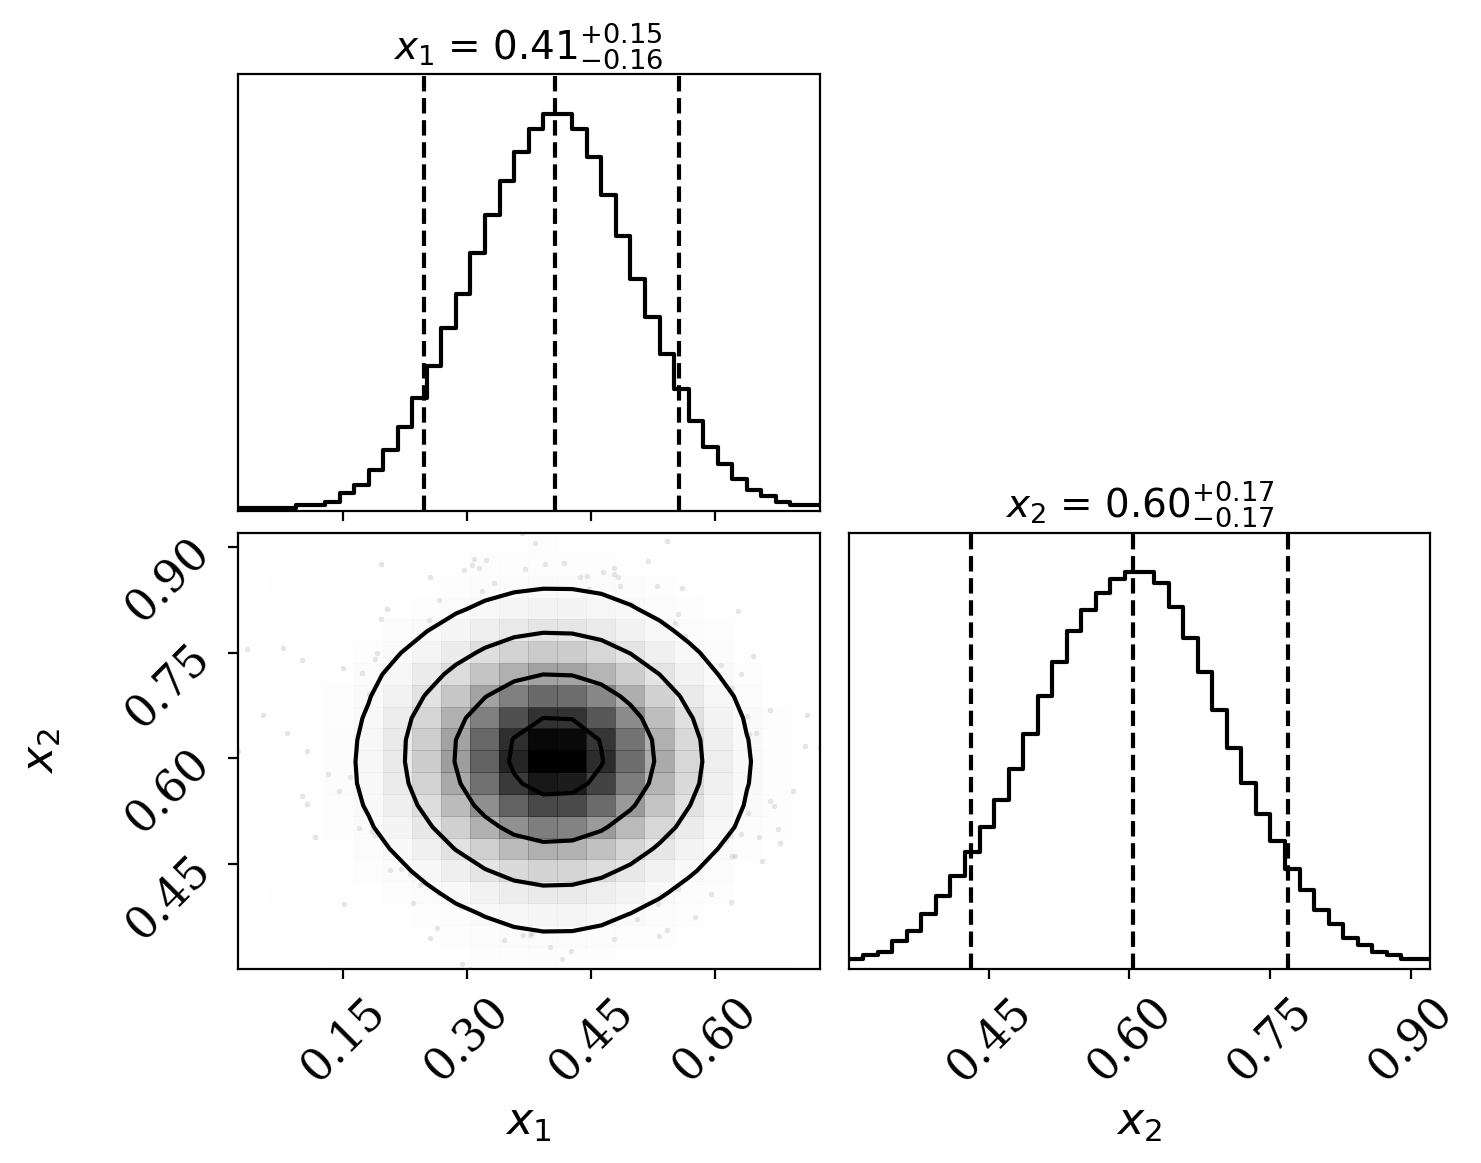

In [11]:
# print(logz_dict)
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

x_grid = np.linspace(0,1,500)
# logz_true = np.log(np.trapz(np.exp(f(x_grid)),x_grid))
# print(f"LogZ True = {logz_true:.4f}")

fig = plt.figure(figsize=(8,6))

fig = corner.corner(samples,labels=[
        r"$x_1$",r"$x_2$"],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)


In [12]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=2,dlogz=0.01)

Nested Sampling took 2.1148s
jaxns made 17003 likelihood evaluations
(480, 2)


(2000, 2)
LogZ logz_mean: -2.5474, dlogz: 0.2013, 


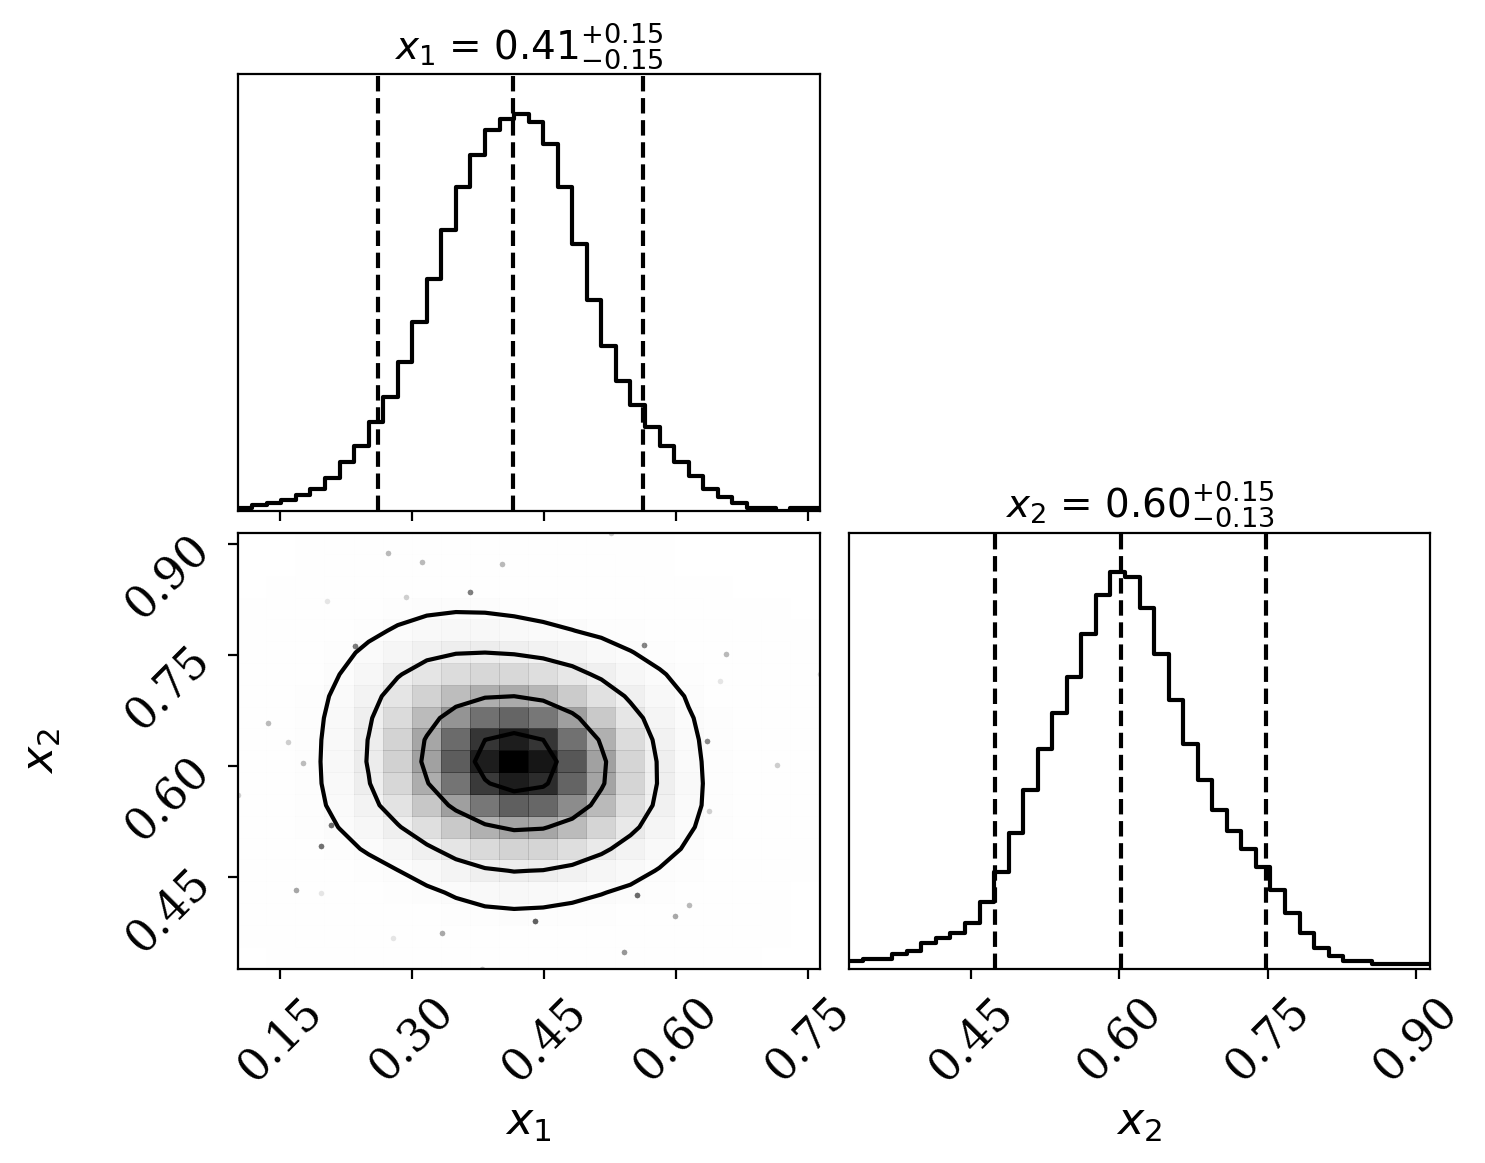

In [13]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

fig = plt.figure(figsize=(8,6))

fig = corner.corner(samples,labels=[
        r"$x_1$",r"$x_2$"],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)


### 4D Example

[[ 0.05772831 -0.01032179  0.00776263 -0.01871472]
 [-0.01032179  0.01840286 -0.01763426 -0.00299651]
 [ 0.00776263 -0.01763426  0.06630701 -0.01788926]
 [-0.01871472 -0.00299651 -0.01788926  0.01883245]]
(32, 4) (32, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 826.69it/s, 31 steps of size 8.74e-02. acc. prob=0.94]


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      1.53      2.06      0.70      0.02      4.16     34.64      0.98
_kernel_inv_length_sq[1]      3.14      7.09      0.95      0.03      5.19     24.98      1.01
_kernel_inv_length_sq[2]      1.52      1.92      0.98      0.00      2.99      9.97      1.16
_kernel_inv_length_sq[3]  55602.23 161950.76  14650.94      0.09  49958.00     34.80      1.03
        kernel_length[0]      3.98      4.04      3.63      0.07      7.55      7.25      1.28
        kernel_length[1]      5.35     12.03      2.38      0.05     10.28     20.93      1.06
        kernel_length[2]      6.07      7.68      3.76      0.08     19.35     10.14      1.36
        kernel_length[3]      0.11      0.18      0.02      0.01      0.40      6.60      1.27
            kernel_tausq      6.97     12.27      0.14      0.00     24.68      6.30      1.35
              kernel_var      1.52      0.52     

Text(0, 0.5, '$x_4$')

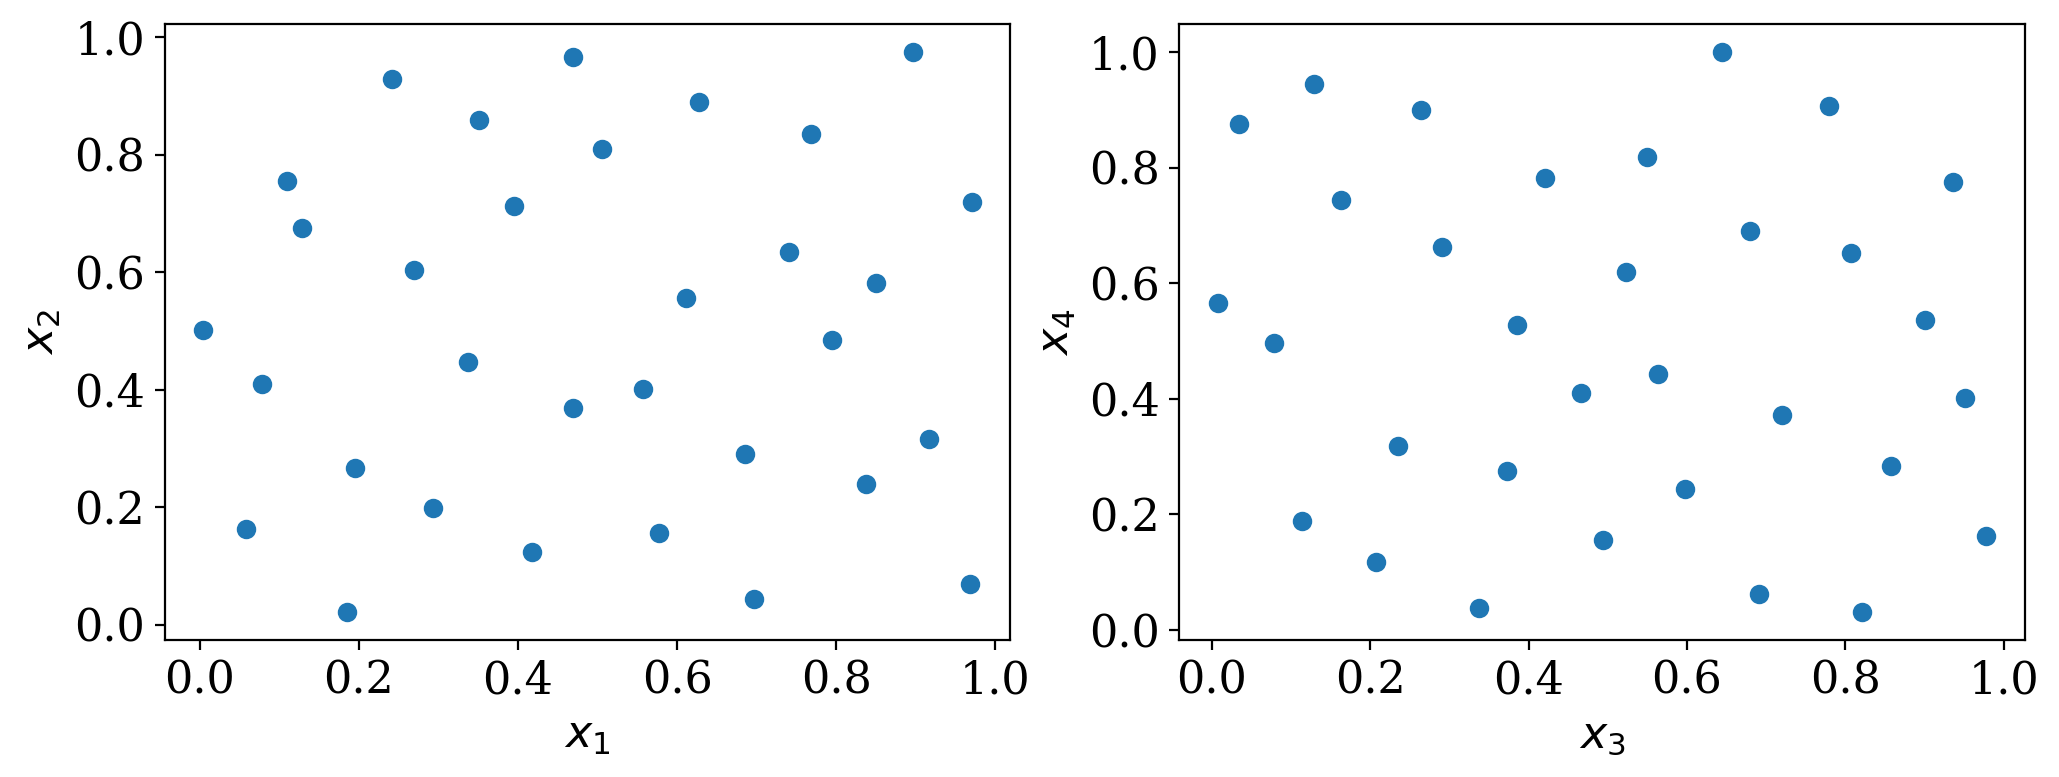

In [18]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 32
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])
cov = cov1 = 0.04*np.eye(ndim) + 0.3*np.random.uniform(-0.1,0.1,(ndim,ndim))
cov = 0.5*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [19]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01)

Nested Sampling took 2.8604s
jaxns made 147844 likelihood evaluations
(1680, 4)


(4000, 4)
LogZ logz_mean: 18.8835, dlogz: 0.2953, 


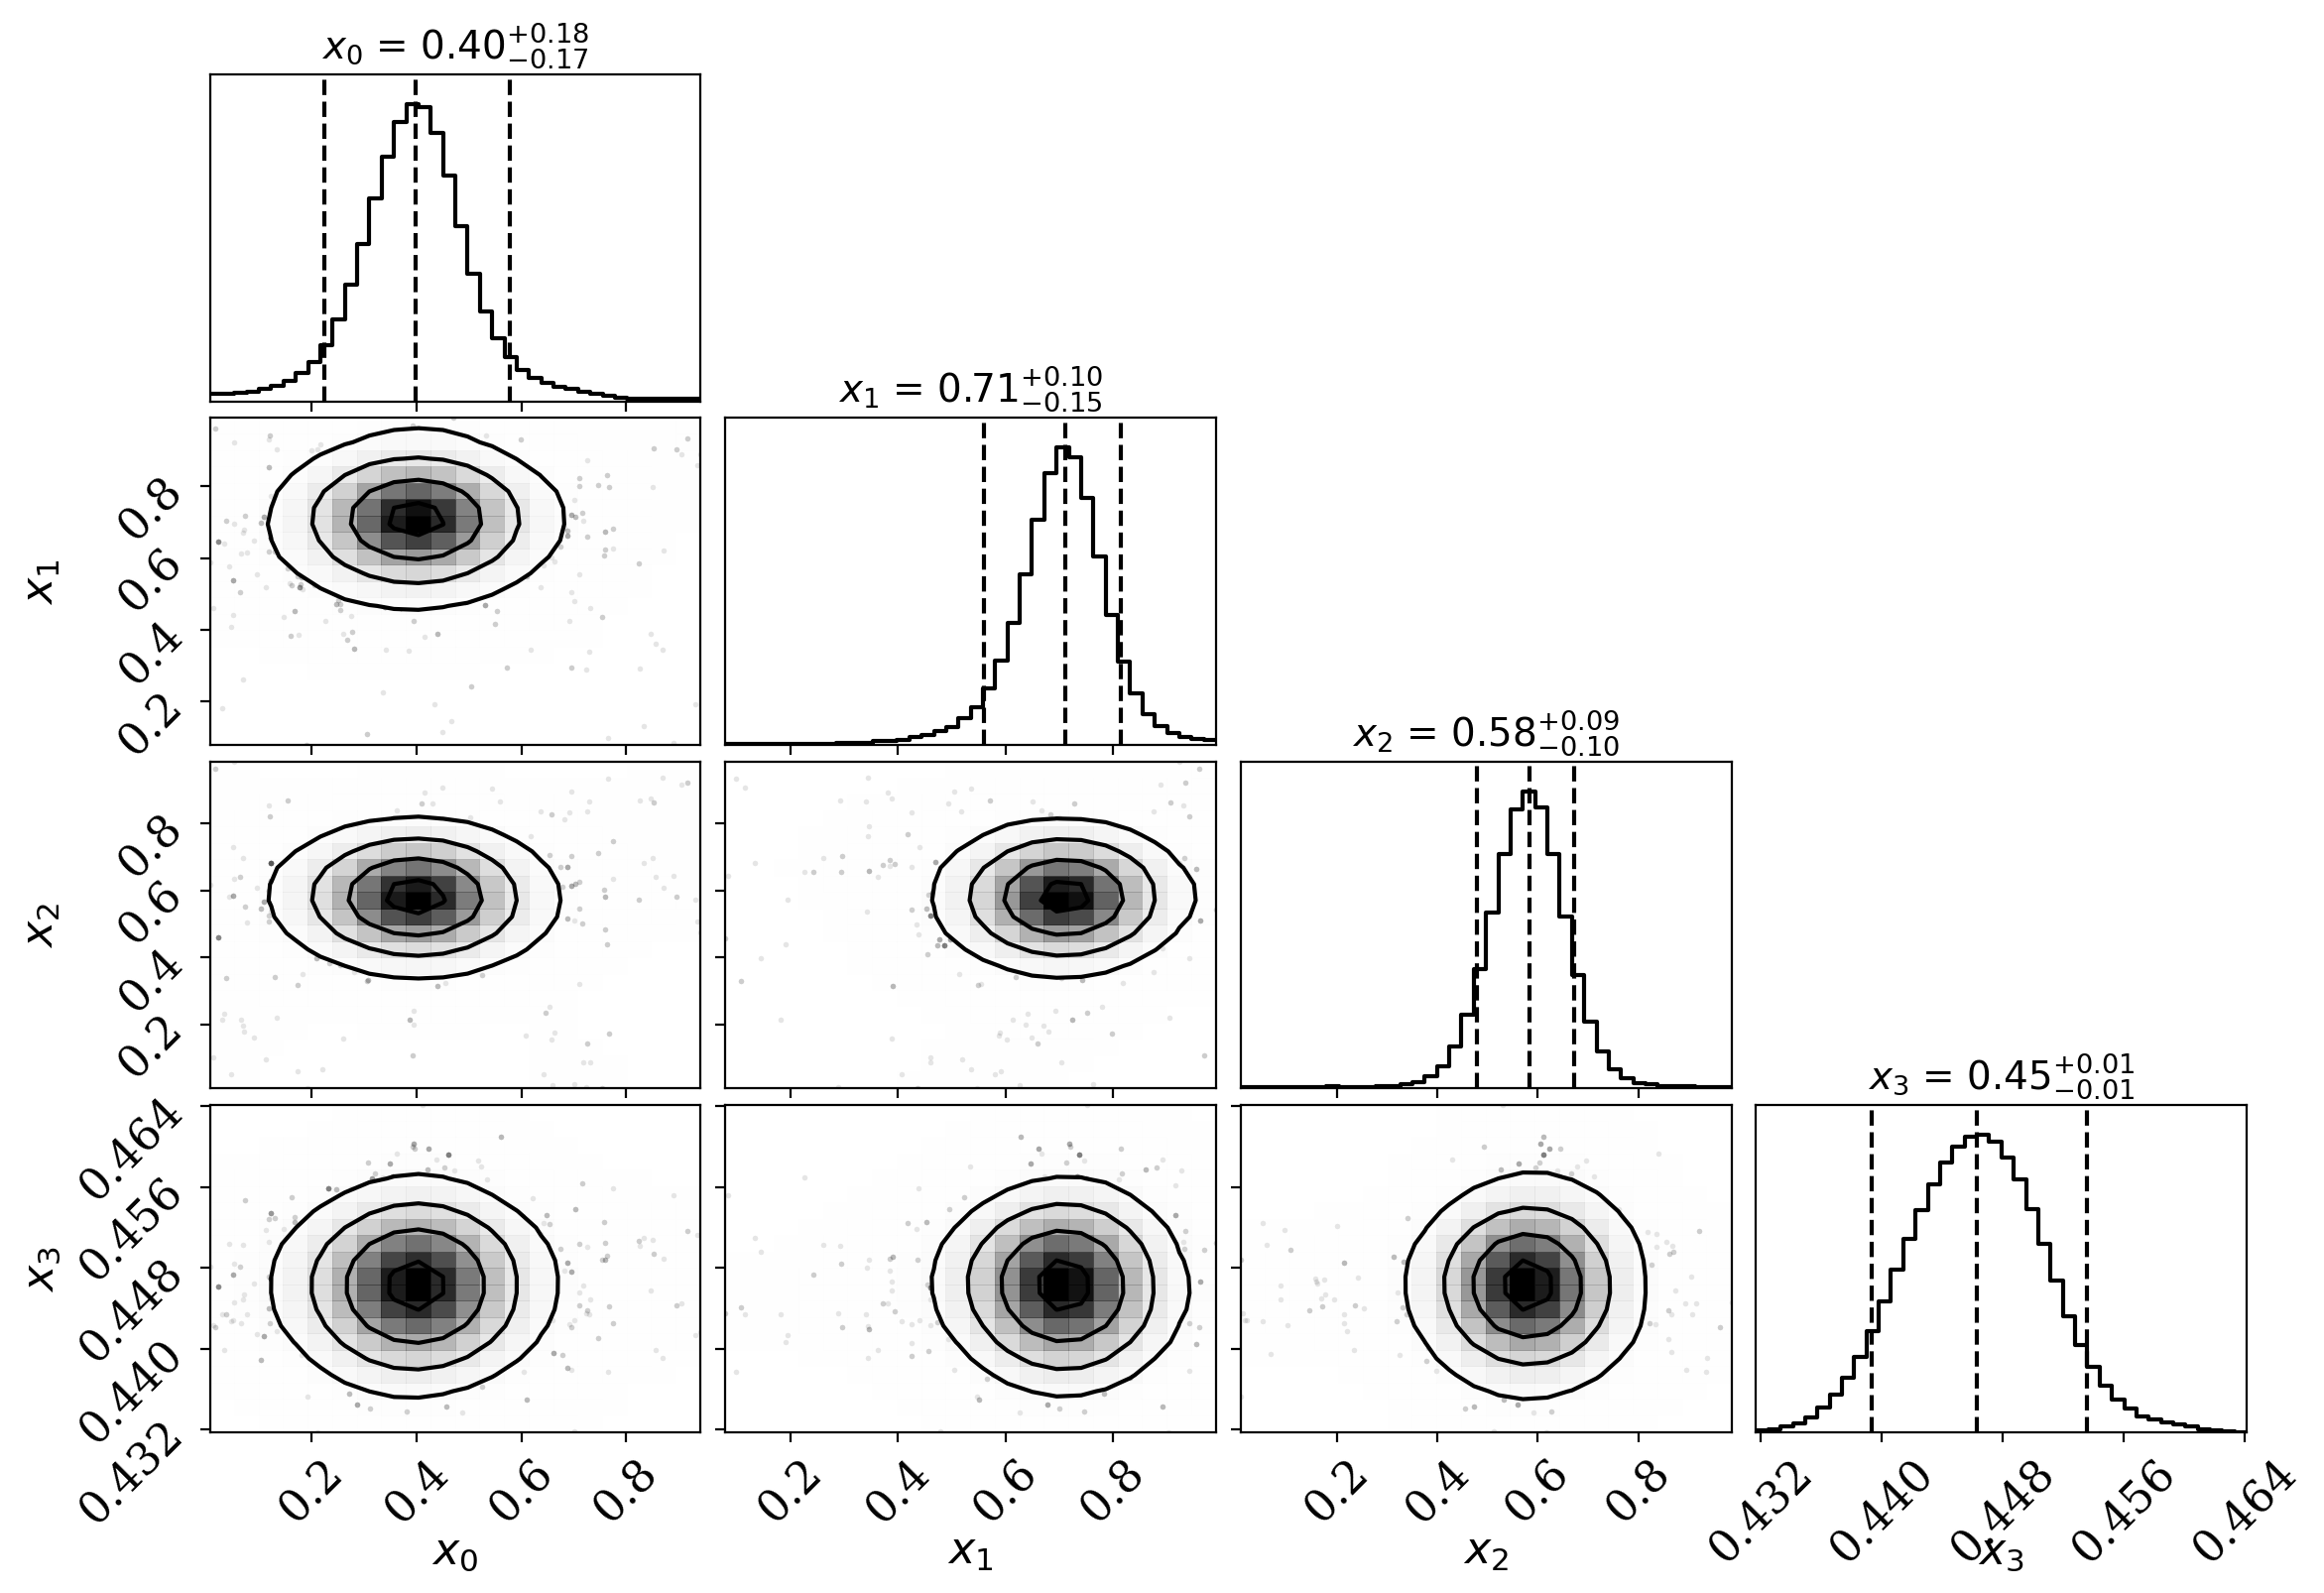

In [20]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
fig = plt.figure(figsize=(12,8))

fig = corner.corner(samples,labels=["$x_{0}$".format(i) for i in range(ndim)],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2.,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)
